# Test trained GAN on COSMOS
Added by Shooby Oct 16th<br>
Last edited Oct 21st

In [1]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.nn.functional as F
from photutils import create_matching_kernel
from skimage.transform import downscale_local_mean
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits
import numpy as np


import astropy.wcs as wcs
from astropy import units as u
from astropy.coordinates import SkyCoord
from scipy import ndimage
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

import os


%matplotlib inline

In [3]:
gs = pyfits.getdata('../../../WFIRST_WPS/CANDELS_fits/cos.fits')
sel1 = (gs['zbest']>0.01)&(gs['zbest']<10.0)&(gs['CLASS_STAR']<0.8)&(gs['Hmag']<25.5)&(gs['ISOAREA_IMAGE_F814W']>=300)&(gs['B_IMAGE']/gs['A_IMAGE']>0.6)

def radec2xy(ra,dec,wc):
    coords = SkyCoord(ra,dec, unit='deg')
    a=wcs.utils.skycoord_to_pixel(coords, wc, origin=0,mode=u'wcs')
    return a[0],a[1]
    
def cut(ra,dec,andaze,filename):
    '''gets coordinates of the galaxy and the filter to return a cutout
    (also called a postage stamp) of the galaxy with given size'''
    hdr = pyfits.getheader(filename)
    w = wcs.WCS(hdr)
    x,y=radec2xy(ra,dec,w)
    x,y=np.int(x),np.int(y)
    im=pyfits.getdata(filename)[y-andaze:y+andaze,x-andaze:x+andaze]
    return im

def brightest_center(im, r = 10):
    
    '''This function is to check whether the central object of the 
    image is the brightest compared to its neighbors in the given cutout.
    Central is defined with a 10x10 pixel square in the center'''
    
    a0,a1 = np.unravel_index(np.argmax(im, axis=None), im.shape)
    ans = False
    if ((a0>((im.shape[0]-r)/2)) & (a0<((im.shape[0]+r)/2)) & (a1>((im.shape[1]-r)/2)) & (a1<((im.shape[0]+r)/2))):
        ans = True
    
    return ans
    

print (len(gs[sel1]))

1155


In [5]:
batchSize = 64          # input batch size
imageSize = 64           # the height / width of the input image to network
ngf = 64
ndf = 64
nz = 100
ngpu = 3       #number of GPUs to use
netG = ''
manualSeed = random.randint(1, 10000)

torch.manual_seed(manualSeed)
device = torch.device("cpu")

nc = 1

class Shoobygen(nn.Module):

    def __init__(self,ngpu):
        super(Shoobygen, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            
            nn.Conv2d(1, ngf * 4, 7, 2, 2, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            
            nn.ConvTranspose2d( ngf*4, ngf * 2, 6, 3, 2,dilation=2, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf * 2, nc, 3, 2, 2, bias=False),
           # nn.BatchNorm2d(ngf * 4),
           # nn.ReLU(True),
  
            #nn.ConvTranspose2d(ngf*4, nc, 4, 1, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
            output1 = output[:,:,:,:]

        else:
            output = self.main(input)
            output1 = output[:,:,:,:]

        return output1


netS = Shoobygen(ngpu).to(device)
netS.load_state_dict(torch.load('../trained_weights/netG_F814W_918.pth',map_location='cpu'))

<All keys matched successfully>

In [7]:
n=15#np.random.randint(1,len(gs[sel1])) 
ra, dec,red = gs['RA'][sel1],gs['DEC'][sel1],gs['zbest'][sel1]
data1 = cut(ra[n],dec[n],32,'/Users/shemmati/Desktop/GOODS/cos_all_acs_wfc_f814w_060mas_v1.0_drz.fits')
if brightest_center(data1):
    plt.imshow(np.arcsinh(data1),vmin=0,origin='lower')
    

FileNotFoundError: [Errno 2] No such file or directory: '/Users/shemmati/Desktop/GOODS/cos_all_acs_wfc_f814w_060mas_v1.0_drz.fits'

In [6]:
dada = np.arcsinh(data1)
galax = (255.0 / (dada.max()+0.05) * (dada - dada.min())).astype(np.uint8)
 
#### images need to be normalized before seeing GAN#########
# from torchvision import transforms
# transforms.normalize(0.5,0.5)(gals)
tfms = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])
im = tfms(galax)
############################################################
#converting to pytorch tensor with the right size
gals = np.repeat(im[:,:,:,np.newaxis],1,axis = 3)
gals =torch.tensor(gals, device="cpu").float()
gals = gals.permute(3,0,1,2)

inputs = gals
real_cpu = inputs.to(device)
ajab = real_cpu.detach()


## Make Kernel
psf = pyfits.getdata('psf_i.fits')
psf = downscale_local_mean(psf,(3,3))
psf = psf[7:-8,7:-8]#[22:-22,22:-22]

psf_hsc = pyfits.getdata('PSF_subaru_i.fits')
psf_hsc = psf_hsc[1:42,1:42]

kern = create_matching_kernel(psf,psf_hsc)
psfh = np.repeat(kern[:,:, np.newaxis], 1, axis=2)
psfh = np.repeat(psfh[:,:,:,np.newaxis],1,axis = 3)
kernel = torch.Tensor(psfh)
kernel = kernel.permute(2,3,0,1)
kernel =  kernel.float()
kernel = kernel.to(device)

## add noise, downsample, convolve with kernel ---> give to GAN
im = real_cpu+0.1*torch.rand_like(real_cpu)
downsampled = F.upsample(im,scale_factor=1/3,mode='bilinear')
img = F.conv2d(downsampled, kernel,padding=int(((kernel.shape[3])-1)/2))
img = img[:,:,:,:]
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(img[0,0,:,:],origin='lower')
plt.colorbar()

data = cut(ra[n],dec[n],11,'/Users/shemmati/Desktop/GOODS/COSMOS.ip.original_psf.v2.fits')
dada = ((data[1:,1:]))
galax = (255.0 / (dada.max()+50.05) * (dada - dada.min())).astype(np.uint8)
tfms = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])
imsub = tfms(galax[:,:])


plt.subplot(1,2,2)
plt.imshow(imsub[0,:,:],origin='lower')
plt.colorbar()

NameError: name 'data1' is not defined

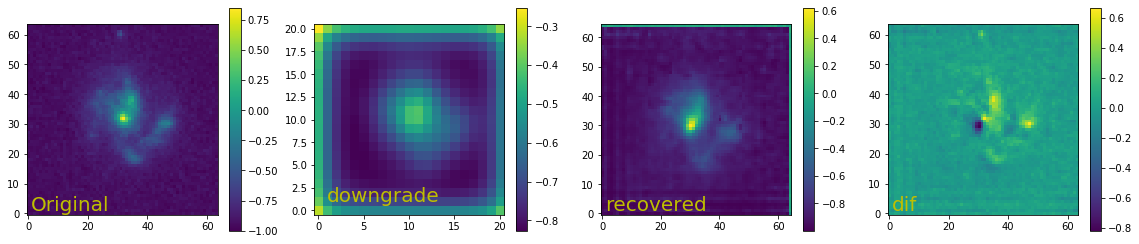

In [109]:
fake = netS(img)
fd = fake.detach()
fd = fd.cpu()

plt.figure(figsize=(16,3.5))
plt.subplot(1,4,1)
plt.imshow(ajab[0,0,:,:],origin='lower')
plt.colorbar()
plt.text(1,1,'Original',color='y',size=20)
plt.subplot(1,4,2)
plt.imshow(img[0,0,:,:],origin='lower')
plt.colorbar()
plt.text(1,1,'downgrade',color='y',size=20)
plt.subplot(1,4,3)
plt.imshow(fd[0,0,:,:],origin='lower')
plt.colorbar()
plt.text(1,1,'recovered',color='y',size=20)
plt.subplot(1,4,4)
plt.imshow(ajab[0,0,:,:]-fd[0,0,:-1,:-1],origin='lower')
plt.colorbar()
plt.text(1,1,'dif',color='y',size=20)

plt.tight_layout()

torch.Size([1, 1, 21, 21])


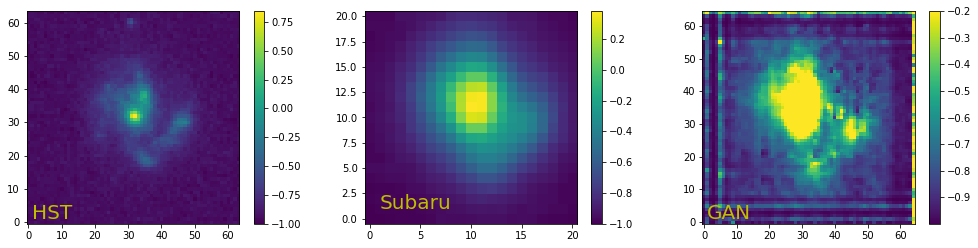

In [110]:
#converting to pytorch tensor with the right size
gals = np.repeat(imsub[:,:,:,np.newaxis],1,axis = 3)
gals =torch.tensor(gals, device="cpu").float()
gals = gals.permute(3,0,1,2)
print(gals.shape)
fake = netS(gals)
fd = fake.detach()
fd = fd.cpu()

plt.figure(figsize=(14,3.5))
plt.subplot(1,3,1)
plt.imshow(ajab[0,0,:,:],origin='lower')
plt.colorbar()
plt.text(1,1,'HST',color='y',size=20)
plt.subplot(1,3,2)
plt.imshow(gals[0,0,:,:],origin='lower')
plt.colorbar()
plt.text(1,1,'Subaru',color='y',size=20)
plt.subplot(1,3,3)
aj = np.array(ajab[0,0,:,:])
plt.imshow(fd[0,0,:,:],vmax=-0.2,origin='lower')
plt.colorbar()
plt.text(1,1,'GAN',color='y',size=20)


plt.tight_layout()
#plt.savefig('plots/COSMOS_F814'+str(n)+'.png')